<a href="https://colab.research.google.com/github/BronsonSchultz/487_A2/blob/main/asn2_q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPT 487, Assignment 1, Question 1
## Bronson Schultz, 1231230, bcs269

# Step 1: Implement the vector gradient.

Implement the vector gradient as described in the lecture slides and the assignment description in the `color_sobel_edges()` function below.  Use sobel filters to estimate partial derivatives.  Use the `color_dot_product()` function (provided) to compute the necessary dot products to obtain gxx, gyy, and gxy.  Return an array containing the gradient magnitudes for each pixel, i.e. a graident magnitude image.  Optionally, return a second array containing the gradient directions for each pixel.

As usual, the input image must be dtype `float` or `uint8`.  If it is `uint8` convert it to `float` before processing.  Leave the magnitude image ouput as dtype `float` regardless of the input's dtype.



In [2]:
# clone of the images required for assignment 
!git clone https://github.com/BronsonSchultz/487_A2.git

Cloning into '487_A2'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.


In [3]:
import skimage.util as util
import skimage.filters as filt
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt


def color_dot_product(A, B):
    '''
    Element-by-element dot product in a 2D array of vectors.

    :return: An array in which index [i,j,:] is the dot product of A[i,j,:] and B[i,j,:].
    '''
    return np.sum(A.conj()*B, axis=2)



def color_sobel_edges(I, return_grad_dir=False):
    '''
    :param I: The input image

    :param return_grad_dir: If return_grad_dir is True, then returns a tuple of 
      (gradient_magnitude, gradient_direction) of the image

    :return: a 2D array of the gradient magnitude for each pixel, or a tuple
    based on return_grad_dir
    '''
    # convert I's dtype to float if it's not already
    if (I.dtype is not float):
      I = util.img_as_float(I)
      
    # create the u and v arrrays as per the assignment description
    u = np.stack([filt.sobel_h(I[:,:,0]), filt.sobel_h(I[:,:,1]), filt.sobel_h(I[:,:,2])], axis=2)
    v = np.stack([filt.sobel_v(I[:,:,0]), filt.sobel_v(I[:,:,1]), filt.sobel_v(I[:,:,2])], axis=2)

    # compute the dot product of the horizontal, vertical and diagonal directions
    g_xx = color_dot_product(u,u)
    g_yy = color_dot_product(v,v)
    g_xy = color_dot_product(u,v)

    # compute the gradient direction and magnitude of the image 
    grad_dir = (1/2) * (np.arctan2((2 * g_xy), (g_xx - g_yy)))
    grad_mag = ((1/2) * ((g_xx + g_yy) + (g_xx - g_yy) * np.cos(2 * (grad_dir)) + 2 * (g_xy) * np.sin(2 * (grad_dir)))) ** (1/2)

    # either return both or just the gradient magnitude array based on the parameter
    if return_grad_dir:
      return (grad_mag, grad_dir)
    else:
       return grad_mag
  

# Step 2: Examine behavior of the kurtosis sharpness metric.

Write a function which:

* takes as input an input image, a minimum value of sigma, and a maximum value of sigma.
* applies different amounts of Gaussian blur to the original image for all integer values of sigma between the provided minimum and maximum values of sigma, inclusive. (reminder: sigma describes the standard deviation of the gaussian filter mask used to blur the image).
* For each blurred image, compute the gradient magnitude using `color_sobel_edges()`, then compute compute the kurtosis sharpness measure.  This is the log(kurtosis+3) where kurtosis is the kurtosis of the gradient magnitude image of the blurred image as described in the assignment description document.  See `scipy.stats.kurtosis()`.
* Returns a tuple consisting of the range object of sigma values used and the list of computed kurtosis values for each sigma.

Call the function using `mushroom.jpg` as the input image, a minimum sigma of 1, and a maximum sigma of 30.  Use a smaller max sigma until you are sure it's working, then increase to 30, as it can take a few minutes to do all the filtering.  Use the return values from your function to plot a line graph of gaussian blur sigma vs. blur measure (kurtosis) for the mushroom image.  Add appropriate axis labels and a descriptive title.  Sample output is provided in the assignment description document.



In [4]:
from scipy.stats import kurtosis
% matplotlib inline

def test_blur_measure(I, min_sigma, max_sigma):
    '''
    :param I: the input image
    :param min_sigma: the minimum value of the standard deviation for the gaussian blur
    :param max_sigma: the maximum value of the standard deviation for the gaussian blur
    :return: a tuple containing a range object of from min_sigma to max_sigma, and the
    list of all sharpness values within that range
    '''
    sharpness_vals = []
    
    for sig in range(min_sigma, max_sigma+1):
      # blur the image with a gaussian filter where the std. deviation = sig
      gaus_blurred_img = filt.gaussian(I, sig, multichannel=True)

      # calculate the image's gradient magnitude array
      grad_mag = color_sobel_edges(gaus_blurred_img)

      # and it's sharpness value
      k = kurtosis(grad_mag.flatten())
      sharpness = np.log(k+3)

      sharpness_vals.append(sharpness)

    return (range(min_sigma, max_sigma+1), sharpness_vals)

mush = io.imread('/content/487_A2/mushroom.jpg')

data = test_blur_measure(mush, 1,30)

Let's plot the sharpness values vs. the sigmas used

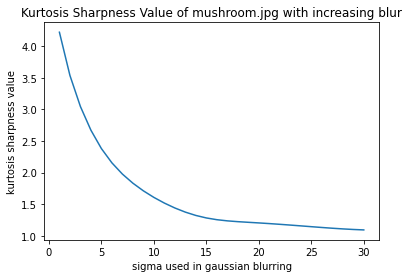

In [11]:
plt.plot(data[0], data[1])
plt.title("Kurtosis Sharpness Value of mushroom.jpg with increasing blur")
plt.ylabel("kurtosis sharpness value")
plt.xlabel("sigma used in gaussian blurring")
plt.show()

# Step 3:  Create a local blur map

Write a function which:

* takes as input an input image and a square window size (in pixels). e.g. if `window_size = 11`, this means an 11 by 11 window.
* computes the local sharpness of the input image (i.e. log(kurtosis+3)) for each tiled, non-overlapping square window of the given window size
* stores each local sharpness in an array where each entry represents one window of the input image (the size of this array can be computed by integer division of the original image dimensions by the window size)
* returns the array of local sharpnesses.

Then call the function you just wrote with `mushroom.jpg` as the input image and 100 as the window size.  Plot the returned array as an image using `plt.imshow()`.  Do not rescale this image with `vmin=` or `vmax=`, and use the default colormap (don't change it to `'gray'`).  Add a color scale bar to the figure using `plt.colorbar()`.  Sample output is provided in the assignment description document.



In [5]:
def sharpness_map(I, window_size):
  '''
  :param I: the input image 
  :param window_size: the width and height of the square window
  :return: an array of sharpness values, one for each window in the image
  '''
  
  local_sharpness_image = np.ndarray((I.shape[0]//window_size, I.shape[1]//window_size))

  # for each top left pixel of our window
  for x in range(0,I.shape[0], window_size):
    for y in range(0, I.shape[1],window_size):
      # slice the window from the image
      window = I[x:x+window_size, y:y+window_size, :]
      # compute its gradient magnitude array
      win_grad_mag = color_sobel_edges(window)

      # calculate its sharpness value
      k = kurtosis(win_grad_mag.flatten())
      sharpness = np.log(k+3)

      # save that value in the shaprness image
      local_sharpness_image[x//window_size-1,y//window_size-1] = sharpness

  return local_sharpness_image

Let's plot the sharpness image

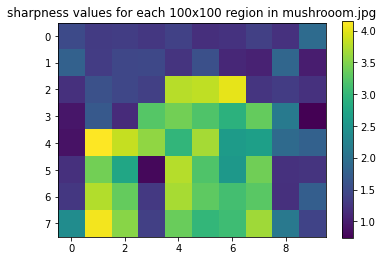

In [6]:
local_sharpness_image = sharpness_map(mush, 100)

plt.imshow(local_sharpness_image)
plt.colorbar()
plt.title('sharpness values for each 100x100 region in mushrooom.jpg')
plt.show()

As well as the original image to compare

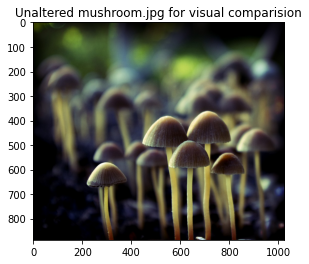

In [7]:
plt.imshow(mush)
plt.title('Unaltered mushroom.jpg for visual comparision')
plt.show()

# Step 4: Try it on another image.

Use the functions you wrote to produce the same plots as in steps 2 and 3 but for the `waterfall.jpg` image instead.


# sharpness measure on `waterfall.jpg` with increasing blur 

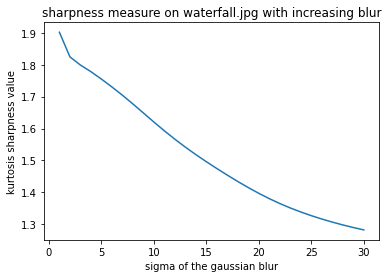

In [8]:
waterfall = io.imread('/content/487_A2/waterfall.jpg')
water_sharps = test_blur_measure(waterfall,1,30)
plt.plot(water_sharps[0], water_sharps[1])
plt.title('sharpness measure on waterfall.jpg with increasing blur')
plt.xlabel('sigma of the gaussian blur')
plt.ylabel('kurtosis sharpness value')
plt.show()

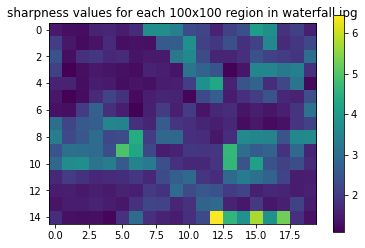

In [9]:
local_sharpness_image = sharpness_map(waterfall, 100)
plt.imshow(local_sharpness_image)
plt.title('sharpness values for each 100x100 region in waterfall.jpg')
plt.colorbar()
plt.show()

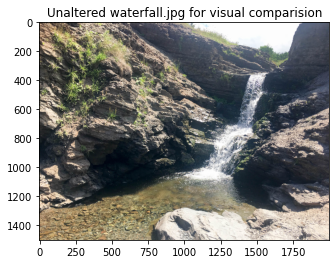

In [10]:
plt.imshow(waterfall)
plt.title('Unaltered waterfall.jpg for visual comparision')
plt.show()

# Step 5: Thinking and Qualitative Analysis

### Answer the following questions, right here in this block.

1. Do you think that the log(kurtosis+3) measurement of sharpness (hereafter called the "sharpness measure") is a good measure for characterizing global image blur (the general amount that the entire image is blurred)?  Explain and justify your answer.

	_Your answer:_  
  >Yes, the sharpness measure seems to give a good representation of how strongly the image is blurred globally. Because, as the sigma of the gaussian used to blur the image increases, the sharpness measure decreases. This is not a linear relation, it is closer to a logarithmic one. So, the greater the blur, the narrower the difference will be in the next sigma step.

2. Is the sharpness measure effective at characterizing variations in local blur?  Does it respond to different regions of images appropriately?  Explain and justify your answers.

	_Your answer:_  
 >looking at the local sharpness maps compared to the true images, we can see how the sharpness measure performs. in mushroom.jpg, the mushrooms in the foreground in in focus while the background is blurred. This is exactly what the sharpness measure finds in the local sharpness image. The foreground objects have a high value, and the background objects have lower values.

  _Your answer:_
  >In waterfall.jpg, the whole image is in focus, so it doesn't perform as perfectly. The sharpness measure seems to prefer objects that are closer to the camera as well as the brightspots in the image, or edges near high contrast. Looking at the local sharpness map, we can see the rocks in the bottom right near the camera as well as the bright rocks near shadowed areas have the highest sharpness values.

3. Think of what the shape of a histogram of gradient magnitudes would look like for a sharp image.  Why does this set of gradient magnitudes have high kurtosis?  (It might help to look up kurtosis and see what it measures about a histogram!)

	_Your answer:_  
  > If the histogram of an image had a high peak with a quick drop off at the ends, then that histogram has a high sharpness. This tall and narrow histogram has a high mean, and the total range of values is smaller than a histogram with a low peak spread over a wider range of values. We know that noise and blur both lower peaks, as well as widens them. A blurry and noisy image will have a lower kurtosis value than a sharp image. 


4. Now think what would happen as that same image gets blurrier.  Explain how the shape of the histogram would change, and the corresponding effect on the kurtosis.

  _Your answer:_  
  > as stated in the previous answer, the more blurry an image becomes, the lower the peak of the histogram becomes and the wider the range of values. Kurtosis measures exactly that, a lower-peak histogram has a lower kurtosis value.